In [204]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [205]:
# today's date string for file naming automation
# today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
today_date_str = '_2024-05-21.csv'

print(today_date_str)

_2024-05-21.csv


In [206]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1412 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,GTBP,"GT Biopharma, Inc.",NASDAQ,11049878.0,USD,7.800,USD,3.9900,USD,4.7000,USD,150.641026,27.884615,1.269076e+06,65006720,65006720,11429196,6508099.2,2.174396e+06,7.337426e+05,113.211712,17.839559,10.221768,8.373300,NaN,Health Technology,6449.725181,1.268630,0.945974,0.656179,1.716975,1.238907,0.815360,0.304145,0.224492,0.224413,1.821422,7740.093110,1087.832926,355.563061,10.6599,USD,10.6599,USD,10.6599,USD,16.11000,USD,146818.035000,USD,7.90,USD,7.90,USD,7.90,USD,7.90,USD,7.90,USD,8.6000,USD,10.6599,USD,10.6599,USD,10.6599,USD,0.000000e+00,USD,7.77594,7.778700,7.74004,7.719031,7.858689,7.734685,7.610681,7.911142,7.721140,7.531138
1,MMV,MultiMetaVerse Holdings Limited,NASDAQ,43955060.0,USD,1.330,USD,1.0800,USD,0.5792,USD,98.036561,82.802979,7.028179e+06,129912247,129916847,14649920,13444922.9,4.499749e+06,1.550222e+06,146.066066,33.023927,17.730675,1.459667,NaN,Consumer Services,3618.068724,2.682282,0.365452,0.365452,1.250226,1.367471,0.777354,0.303840,0.178365,0.178196,1.022929,284.500846,232.959780,134.479841,2.0500,USD,2.0500,USD,2.0500,USD,4.00000,USD,18.600010,USD,1.35,USD,1.37,USD,1.42,USD,1.42,USD,1.42,USD,1.5500,USD,2.0500,USD,2.0500,USD,2.0500,USD,1.112129e+05,USD,1.31422,1.311375,1.32766,1.300500,1.397522,1.331190,1.264858,1.385548,1.288980,1.192412
2,FFIE,Faraday Future Intelligent Electric Inc.,NASDAQ,76810964.0,USD,1.800,USD,1.1000,USD,0.9400,USD,91.262136,6.796117,3.755077e+07,701627164,701643326,119418665,677677032.5,2.614243e+08,9.661288e+07,101.666667,216.817350,64.024792,1.750000,NaN,Consumer Durables,1.051061,18.037560,1.926070,1.682808,1.972990,2.754692,2.698007,1.189128,0.346667,0.183184,0.206416,1.141916,0.914813,37.129566,3.9000,USD,3.9000,USD,3.9000,USD,117.36000,USD,4980.000000,USD,1.80,USD,1.80,USD,1.80,USD,1.80,USD,1.80,USD,1.8000,USD,2.2500,USD,2.2500,USD,3.9000,USD,0.000000e+00,USD,1.76342,1.735750,1.66206,1.558400,1.801141,1.656825,1.512509,1.707881,1.542535,1.377189
3,CRKN,Crown Electrokinetics Corp.,NASDAQ,10288705.0,USD,0.199,USD,0.1596,USD,0.1050,USD,61.403509,-6.666667,5.137255e+07,751743632,751794402,206060696,658674541.3,2.239864e+08,7.676532e+07,85.430464

In [207]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [208]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,GTBP,"GT Biopharma, Inc.",NASDAQ,11049878.0,USD,7.800,USD,3.9900,USD,4.7000,USD,150.641026,27.884615,1.269076e+06,65006720,65006720,11429196,6508099.2,2.174396e+06,7.337426e+05,113.211712,17.839559,10.221768,8.373300,NaN,Health Technology,6449.725181,1.268630,0.945974,0.656179,1.716975,1.238907,0.815360,0.304145,0.224492,0.224413,1.821422,7740.093110,1087.832926,355.563061,10.6599,USD,10.6599,USD,10.6599,USD,16.11000,USD,146818.035000,USD,7.90,USD,7.90,USD,7.90,USD,7.90,USD,7.90,USD,8.6000,USD,10.6599,USD,10.6599,USD,10.6599,USD,0.000000e+00,USD,7.77594,7.778700,7.74004,7.719031,7.858689,7.734685,7.610681,7.911142,7.721140,7.531138,Shrimp
1,MMV,MultiMetaVerse Holdings Limited,NASDAQ,43955060.0,USD,1.330,USD,1.0800,USD,0.5792,USD,98.036561,82.802979,7.028179e+06,129912247,129916847,14649920,13444922.9,4.499749e+06,1.550222e+06,146.066066,33.023927,17.730675,1.459667,NaN,Consumer Services,3618.068724,2.682282,0.365452,0.365452,1.250226,1.367471,0.777354,0.303840,0.178365,0.178196,1.022929,284.500846,232.959780,134.479841,2.0500,USD,2.0500,USD,2.0500,USD,4.00000,USD,18.600010,USD,1.35,USD,1.37,USD,1.42,USD,1.42,USD,1.42,USD,1.5500,USD,2.0500,USD,2.0500,USD,2.0500,USD,1.112129e+05,USD,1.31422,1.311375,1.32766,1.300500,1.397522,1.331190,1.264858,1.385548,1.288980,1.192412,Shrimp
2,FFIE,Faraday Future Intelligent Electric Inc.,NASDAQ,76810964.0,USD,1.800,USD,1.1000,USD,0.9400,USD,91.262136,6.796117,3.755077e+07,701627164,701643326,119418665,677677032.5,2.614243e+08,9.661288e+07,101.666667,216.817350,64.024792,1.750000,NaN,Consumer Durables,1.051061,18.037560,1.926070,1.682808,1.972990,2.754692,2.698007,1.189128,0.346667,0.183184,0.206416,1.141916,0.914813,37.129566,3.9000,USD,3.9000,USD,3.9000,USD,117.36000,USD,4980.000000,USD,1.80,USD,1.80,USD,1.80,USD,1.80,USD,1.80,USD,1.8000,USD,2.2500,USD,2.2500,USD,3.9000,USD,0.000000e+00,USD,1.76342,1.735750,1.66206,1.558400,1.801141,1.656825,1.512509,1.707881,1.542535,1.377189,Micro caps
3,CRKN,Crown Electrokinetics Corp.,NASDAQ,10288705.0,USD,0.199,USD,0.1596,USD,0.1050,USD,61.403509,-6.666667,5.137255e+07,751743632,751794402,206060696,65867454

In [209]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [210]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1412 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,311,22.025496
1,Shrimp,308,21.813031
2,Midlers,263,18.626062
3,Micro caps,256,18.130312
4,Large caps,241,17.067989
5,Titans,21,1.487252
6,Undefined,12,0.849858


In [211]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

490 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
598,NVDA,NVIDIA Corporation,NASDAQ,2.369500e+12,USD,947.800,USD,933.800,USD,12.4400,USD,1.345170,0.974275,2.400722e+09,31874880,31876446,425158,34826902.4,4.298579e+07,4.977711e+07,2.912029,2.704059,3.519160,944.733333,79.403510,Electronic Technology,0.890881,2.204621,2.430273,1.748256,2.543491,2.433757,2.020378,1.379290,0.578047,0.328567,0.543348,0.900384,0.137687,0.516215,958.1899,USD,974.0000,USD,974.0000,USD,974.0000,USD,974.0000,USD,948.3400,USD,948.7500,USD,951.8000,USD,951.8000,USD,951.8000,USD,951.9400,USD,952.0000,USD,952.0000,USD,958.1899,USD,2.058176e+06,USD,946.69200,946.687837,948.05940,949.479900,949.498852,947.607690,945.716528,952.066683,949.52839,946.990097,Titans
1226,DEO,Diageo plc,NYSE,7.879481e+10,USD,140.550,USD,142.650,USD,0.2500,USD,0.175562,0.175562,5.550436e+08,412296,412296,447,479032.2,7.131459e+05,7.540900e+05,1.417278,0.961520,0.905204,141.035367,19.832087,Consumer Non-Durables,0.879738,0.729834,0.572654,0.672891,10.049830,5.291097,6.869217,6.744416,3.702879,2.073001,1.288125,0.852819,0.126405,0.515888,144.2700,USD,154.7100,USD,154.7100,USD,179.7800,USD,223.1363,USD,140.7500,USD,140.8250,USD,140.8250,USD,140.8250,USD,140.8250,USD,141.4600,USD,142.1461,USD,142.1461,USD,144.2700,USD,6.800116e+05,USD,140.65332,140.685825,140.60400,140.659238,140.853536,140.677080,140.500624,140.984991,140.72955,140.474109,Large caps
1345,TILE,"Interface, Inc.",NASDAQ,8.925714e+08,USD,15.325,USD,15.550,USD,0.0100,USD,0.064350,0.064350,5.617547e+07,306188,306188,100,394477.1,4.836932e+05,3.991302e+05,1.672765,2.067614,3.296472,15.396333,15.201865,Producer Manufacturing,0.590968,1.632766,1.834374,1.996698,1.693292,4.830983,6.808308,5.397071,1.998756,1.131546,0.946697,0.701130,0.119546,0.984953,18.1750,USD,18.4699,USD,18.4699,USD,18.4699,USD,27.1700,USD,15.3400,USD,15.3500,USD,15.3500,USD,15.3500,USD,15.3500,USD,15.4600,USD,15.5600,USD,15.5600,USD,18.1750,USD,3.485764e+05,USD,15.32700,15.328125,15.33600,15.340000,15.347207,15.329750,15.312293,15.382824,15.34600,15.309176,Small caps
778,SWBI,"Smith & Wesson Brands, Inc.",NASDAQ,7.287236e+08,USD,16.010,USD,16.480,USD,0.1300,USD

In [212]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [213]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_wmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vwap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vwap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vwap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vwap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vwap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vwap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vwap_drawdown_threshold = config.get("pre_market_vwap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vwap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [214]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 490
Number of rows removed: 484
NEW DataFrame length: 6


In [215]:
# need to add error handling for when zero (0) return (4/4/24)

In [216]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Large caps,3,50.000000
1,Midlers,2,33.333333
2,Small caps,1,16.666667


In [217]:
### ADD 'TSLA' TO THE DATAFRAME ####


In [218]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Large caps' 'Midlers' 'Small caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'Relative V

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,COIN,"Coinbase Global, Inc.",NASDAQ,5.529967e+10,USD,225.19,USD,207.84,USD,0.11,USD,0.052987,0.115607,1.879471e+08,11221977,11223310,91455,7919159.4,8.910322e+06,1.238760e+07,11.064206,7.644996,6.751693,218.390000,44.974137,Finance,1.500896,2.629659,3.468595,3.468595,1.491201,2.046133,3.315034,3.310326,2.035859,0.984923,1.277238,1.445010,0.221988,0.500213,239.00,USD,283.48,USD,283.4800,USD,283.4800,USD,429.5400,USD,225.365,USD,226.26,USD,226.26,USD,226.26,USD,226.26,USD,226.26,USD,226.26,USD,226.26,USD,235.80,USD,9.099482e+05,USD,224.44338,224.797200,224.85804,222.353869,226.198877,224.68223,223.165583,226.408901,220.891075,215.373249,Large caps
1,TER,"Teradyne, Inc.",NASDAQ,2.177917e+10,USD,139.51,USD,135.39,USD,3.16,USD,2.395573,2.638162,1.536180e+08,3406257,3406257,10312,2293796.8,2.488732e+06,2.041227e+06,6.169723,2.508320,2.769546,138.140000,53.102162,Electronic Technology,1.700297,2.055360,1.722324,1.502452,7.264457,11.461038,8.080038,4.387580,1.925272,1.188186,1.130589,1.576220,0.316788,0.928916,140.22,USD,140.22,USD,140.2200,USD,140.2200,USD,168.9100,USD,139.770,USD,139.77,USD,139.96,USD,139.96,USD,139.96,USD,139.97,USD,140.22,USD,140.22,USD,140.22,USD,4.108815e+05,USD,139.55500,139.496875,139.60400,139.489362,139.831348,139.53400,139.236652,140.013090,139.265085,138.517080,Large caps
2,SNX,TD SYNNEX Corporation,NYSE,1.110637e+10,USD,127.44,USD,127.12,USD,0.81,USD,0.641279,0.641279,7.753561e+07,810800,810800,100,645053.9,7.543603e+05,9.404181e+05,1.551492,1.323691,1.369109,127.346667,18.492077,Distribution Services,1.428984,0.725466,1.154095,1.590319,2.504247,5.957052,4.621840,3.510319,1.744224,0.894460,1.409927,1.311450,0.152951,0.678461,128.27,USD,128.27,USD,128.2700,USD,128.2700,USD,130.9300,USD,127.420,USD,127.54,USD,127.77,USD,127.77,USD,127.77,USD,128.12,USD,128.27,USD,128.27,USD,128.27,USD,2.502409e+06,USD,127.30700,127.330625,127.51200,127.706154,127.707433,127.44325,127.179067,128.244696,127.808750,127.372804,Large caps
3,CEIX,CONSOL Energy Inc.,NYSE,2.760121e+09,USD,93.92,USD,90.88,USD,0.19,USD,0.209505,0.209505,2.875733e+07,544274,544274,200,415142.6,3.756247e+

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [219]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [220]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [221]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [222]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 6/6 [00:00<00:00, 827.71it/s]


In [223]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-12-21
END date: 2024-05-20
103 days of historical stock data.

618 = Length of dataframe
6 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['COIN', 'TER', 'SNX', 'CEIX', 'KGS', 'CRAI']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
608,161.72,163.8500,160.30,160.75,2024-05-07,CRAI,37389,HISTORICAL_PRICES,CRAI,,2024-05-07,1.715874e+12,0.614455,0.614455,160.75,161.72,163.8500,160.30,37389,160.75,161.72,163.8500,160.30,37389,"May 7, 24",0.97,0.0060,CRAI
609,161.70,163.2727,160.66,161.72,2024-05-08,CRAI,36578,HISTORICAL_PRICES,CRAI,,2024-05-08,1.715874e+12,0.614256,0.614256,161.72,161.70,163.2727,160.66,36578,161.72,161.70,163.2727,160.66,36578,"May 8, 24",-0.02,-0.0001,CRAI
610,164.03,164.9300,160.93,162.98,2024-05-09,CRAI,23133,HISTORICAL_PRICES,CRAI,,2024-05-09,1.715874e+12,0.637516,0.637516,162.98,164.03,164.9300,160.93,23133,162.98,164.03,164.9300,160.93,23133,"May 9, 24",2.33,0.0144,CRAI
611,164.74,165.1700,164.03,164.03,2024-05-10,CRAI,28080,HISTORICAL_PRICES,CRAI,,2024-05-10,1.715874e+12,0.644604,0.644604,164.03,164.74,165.1700,164.03,28080,164.03,164.74,165.1700,164.03,28080,"May 10, 24",0.71,0.0043,CRAI
612,164.70,166.4300,164.18,166.02,2024-05-13,CRAI,39605,HISTORICAL_PRICES,CRAI,,2024-05-13,1.715874e+12,0.644205,0.644205,166.02,164.70,166.4300,164.18,39605,166.02,164.70,166.4300,164.18,39605,"May 13, 24",-0.04,-0.0002,CRAI
613,167.34,167.6700,164.96,166.32,2024-05-14,CRAI,22190,HISTORICAL_PRICES,CRAI,,2024-05-14,1.715874e+12,0.670560,0.670560,166.32,167.34,167.6700,164.96,22190,166.32,167.34,167.6700,164.96,22190,"May 14, 24",2.64,0.0160,CRAI
614,170.10,171.6699,167.35,167.35,2024-05-15,CRAI,40662,HISTORICAL_PRICES,CRAI,,2024-05-15,1.715874e+12,0.698113,0.698113,167.35,170.10,171.6699,167.35,40662,167.35,170.10,171.6699,167.35,40662,"May 15, 24",2.76,0.0165,CRAI
615,171.07,173.8100,170.30,170.82,2024-05-16,CRAI,19054,HISTORICAL_PRICES,CRAI,,2024-05-16,1.715934e+12,0.707797,0.707797,170.82,171.07,173.8100,170.30,19054,170.82,171.07,173.8100,170.30,19054,"May 16, 24",0.97,0.0057,CRAI
616,170.64,172.0000,169.32,172.00,2024-05-17,CRAI,25137,HISTORICAL_PRICES,CRAI,,2024-05-17,1.716020e+12,0.703504,0.703504,172.00,170.64,172.0000,169.32,25137,172.00,170.64,172.0000,169.32,25137,"May 17, 24",-0.43,-0.0025,CRAI
617,174.55,178.5200,170.02,172.00,2024-05-20,CRAI,59758,HISTORICAL_PRICES,CRAI,,2024-05-20,1.716262e+12,0.742538,0.742538,172.00,174.55,178.5200,170.02,59758,172.00,174.55,178.5200,170.02,59758,"May 20, 24",3.91,0.0229,CRAI


In [224]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [225]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,CEIX,2024-05-20,93.92,94.31,90.21,91.50,544274
1,COIN,2024-05-20,225.19,226.26,203.72,207.96,11223310
2,CRAI,2024-05-20,174.55,178.52,170.02,172.00,59758
3,KGS,2024-05-20,28.96,29.43,28.61,28.61,514609
4,SNX,2024-05-20,127.44,128.27,126.33,126.33,810800
5,TER,2024-05-20,139.51,140.22,134.69,135.00,3406257


In [226]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 618


In [227]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [228]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,COIN,2023-12-21,168.03,170.170,163.1000,166.71,12081482
309,CEIX,2023-12-21,100.74,101.820,99.7501,99.85,365338
412,KGS,2023-12-21,19.72,19.850,19.4800,19.48,418522
206,SNX,2023-12-21,107.04,107.225,106.1250,107.03,278052
515,CRAI,2023-12-21,100.17,103.330,100.0800,102.60,52657


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [229]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-12-21,COIN,168.03,170.170,163.1000,166.71,12081482
2023-12-21,CEIX,100.74,101.820,99.7501,99.85,365338
2023-12-21,KGS,19.72,19.850,19.4800,19.48,418522
2023-12-21,SNX,107.04,107.225,106.1250,107.03,278052
2023-12-21,CRAI,100.17,103.330,100.0800,102.60,52657


# TREND LINES - UNIT TESTING

| TICKER - Unit TESTING | 
|-|

In [230]:
# filter by symbol
ticker = 'COIN'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-05-07,COIN,214.34,230.8200,214.120,226.94,8169566
2024-05-08,COIN,211.20,214.9000,206.525,209.50,4615442
2024-05-09,COIN,210.45,213.8497,205.110,210.22,4649731
2024-05-10,COIN,200.92,214.8700,200.500,214.50,7423528
2024-05-13,COIN,199.51,206.6650,197.640,204.00,7542161
2024-05-14,COIN,203.05,206.9669,194.930,195.96,5356047
2024-05-15,COIN,219.91,221.4000,207.700,212.21,9339278
2024-05-16,COIN,199.17,216.4000,198.640,215.00,3484726
2024-05-17,COIN,207.60,210.6700,199.870,205.66,2478980


In [231]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-07,COIN,214.34,230.8200,214.120,226.94,8169566
2024-05-08,COIN,211.20,214.9000,206.525,209.50,4615442
2024-05-09,COIN,210.45,213.8497,205.110,210.22,4649731
2024-05-10,COIN,200.92,214.8700,200.500,214.50,7423528
2024-05-13,COIN,199.51,206.6650,197.640,204.00,7542161
2024-05-14,COIN,203.05,206.9669,194.930,195.96,5356047
2024-05-15,COIN,219.91,221.4000,207.700,212.21,9339278
2024-05-16,COIN,199.17,216.4000,198.640,215.00,3484726
2024-05-17,COIN,207.60,210.6700,199.870,205.66,2478980


In [232]:
# save unit test dataframe to csv
ticker_df.to_csv(f'unit_TEST/historical_data_{ticker}{today_date_str}.csv', index=True)

# ADVANCED WIP

In [233]:
ticker_df.head(6)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2023-12-21,COIN,168.03,170.1700,163.10,166.71,12081482
2023-12-22,COIN,175.48,178.6955,167.90,169.77,15832867
2023-12-26,COIN,172.05,178.1200,169.05,174.80,12544846
2023-12-27,COIN,185.24,186.9700,175.50,176.32,15569914
2023-12-28,COIN,186.36,187.3900,177.75,179.31,17276287
2023-12-29,COIN,173.92,187.2500,171.00,186.06,19724384


| ADVANCED CHARTING | 
|-|
| Trend Lines | 

In [234]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative value if invalid 
    
    intercept = -slope * pivot + y.iloc[pivot]  # Using .iloc[] for positional indexing
    line_vals = slope * np.arange(len(y)) + intercept  # Calculate line values
    diffs = line_vals - y  # Calculate differences between line values and actual values
    
    if support and diffs.max() > 1e-5:
        return -1.0  # Line is not valid for support
    elif not support and diffs.min() < -1e-5:
        return -1.0  # Line is not valid for resistance
    
    err = (diffs ** 2.0).sum()  # Calculate sum of squared errors
    return err

def optimize_slope(support: bool, pivot: int, init_slope: float, y: np.array):
    slope_unit = (y.max() - y.min()) / len(y)  # Determine the unit change for slope
    
    # Initialize optimization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    
    assert(best_err >= 0.0)  # Initial slope should not produce an error
    
    get_derivative = True
    derivative = None
    while curr_step > min_step:
        if get_derivative:
            # Numerical differentiation to find the direction to adjust slope
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err

            if test_err < 0.0:  # If increasing slope fails, try decreasing
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0:  # If derivative failed, abort optimization
                raise Exception("Derivative failed. Check your data.")

            get_derivative = False

        if derivative > 0.0:  # If increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else:  # If increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        
        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err:  # If slope failed or didn't reduce error
            curr_step *= 0.5  # Reduce step size
        else:  # If test slope reduced error
            best_err = test_err
            best_slope = test_slope
            get_derivative = True  # Recompute derivative
    
    return (best_slope, -best_slope * pivot + y.iloc[pivot])  # Using .iloc[] for positional indexing

def fit_trendlines_single(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line
    
    # Find pivot points
    upper_pivot = (data - line_points).argmax()
    lower_pivot = (data - line_points).argmin()
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs)

def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line

    # Find pivot points
    upper_pivot = (high - line_points).argmax()
    lower_pivot = (low - line_points).argmin()
    
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)


In [235]:
# should be based on 72 periods but displayed as 24 periods maybe? nah?

In [236]:
# step 1: fit trendlines for each stock
support_coefs, resist_coefs = fit_trendlines_high_low(ticker_df['High'], ticker_df['Low'], ticker_df['Close'])

In [237]:
# step 2: calculate trendlines
x_values = np.arange(len(ticker_df))  # Use the actual data range

# Calculate the line values using the coefficients
support_line = support_coefs[0] * x_values + support_coefs[1]
resistance_line = resist_coefs[0] * x_values + resist_coefs[1]

| ADVANCED CHARTING |
|-|
| Line of Best Fit (Regression Line) |
| Pivot point Xs |
| CLOSE |

In [238]:
# linear regresion
last_72_df = ticker_df.iloc[-72:]
X = np.arange(len(last_72_df)).reshape(-1, 1)
y = last_72_df['Close'].values.reshape(-1, 1)

model = LinearRegression().fit(X, y)
best_fit_last_72 = model.predict(X).flatten()

# Preparing the regression line plot data
best_fit_series = pd.Series([np.nan] * len(ticker_df))
best_fit_series.iloc[-72:] = best_fit_last_72


In [239]:
# # Identify the pivot points within the last 72 periods
# pivot_point_low_index = last_72_df['Close'].idxmin()
# pivot_point_high_index = last_72_df['Close'].idxmax()

In [240]:
# # Initialize series for pivot points with NaN values
# pivot_points_high_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)
# pivot_points_low_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)

# # Set the pivot point values
# pivot_points_high_series[pivot_point_high_index] = ticker_df.loc[pivot_point_high_index, 'Close']
# pivot_points_low_series[pivot_point_low_index] = ticker_df.loc[pivot_point_low_index, 'Close']

| ADVANCED CHARTING |
|-|
| Extending the trend and regression lines to the future |

In [241]:
# # Extend x_values for future predictions
# future_line_periods = 10
# current_periods = len(ticker_df)
# extended_x_values = np.arange(current_periods + future_line_periods)

# # Calculate extended trend lines
# extended_support_line = support_coefs[0] * extended_x_values + support_coefs[1]
# extended_resistance_line = resist_coefs[0] * extended_x_values + resist_coefs[1]

# # Calculate extended line of best fit
# X_future = np.arange(-72, future_line_periods).reshape(-1, 1)  # -72 for last 72 periods and future periods
# extended_best_fit = model.predict(X_future).flatten()

| ADVANCED CHARTING - CHART IT |
|-|
| Candlestick Chart (KEY Levels overlayed) |


In [242]:
# prepare the plot
apds = [mpf.make_addplot(support_line, color='green', width=2),
        mpf.make_addplot(resistance_line, color='red', width=2),
        mpf.make_addplot(best_fit_series, color='orange', width=2)]        
        # mpf.make_addplot(pivot_points_high_series, type='scatter', markersize=100, marker='x', color='green'),
        # mpf.make_addplot(pivot_points_low_series, type='scatter', markersize=100, marker='x', color='red')]

In [243]:
# look at the df
ticker_df.tail(10)

# youre going to have to create some placeholders here.
# another df?

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-07,COIN,214.34,230.8200,214.120,226.94,8169566
2024-05-08,COIN,211.20,214.9000,206.525,209.50,4615442
2024-05-09,COIN,210.45,213.8497,205.110,210.22,4649731
2024-05-10,COIN,200.92,214.8700,200.500,214.50,7423528
2024-05-13,COIN,199.51,206.6650,197.640,204.00,7542161
2024-05-14,COIN,203.05,206.9669,194.930,195.96,5356047
2024-05-15,COIN,219.91,221.4000,207.700,212.21,9339278
2024-05-16,COIN,199.17,216.4000,198.640,215.00,3484726
2024-05-17,COIN,207.60,210.6700,199.870,205.66,2478980


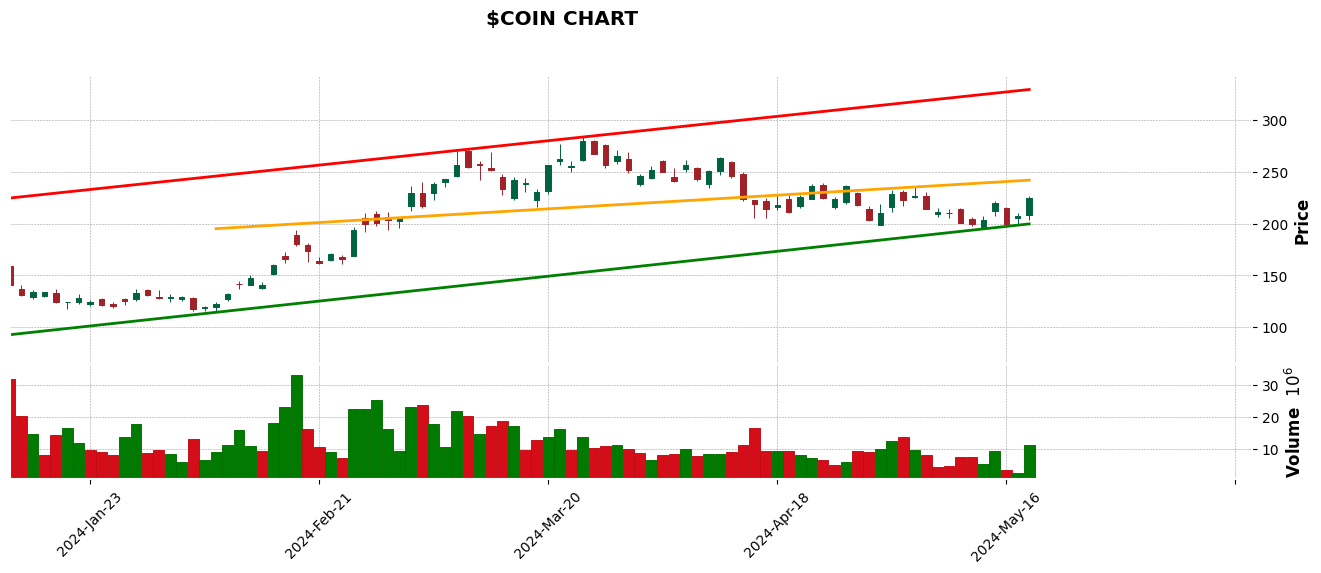

In [244]:
#### CHART IT ####
# Define the period for the x-axis view and future extension
lookback_periods = 90
future_periods = 20

# Calculate the extended index for the lookback period
lookback_index = ticker_df.index[-lookback_periods]

# Generate the future index by adding the future periods to the last date
future_index = pd.date_range(start=ticker_df.index[-1] + pd.Timedelta(days=1),
                             periods=future_periods, freq='B')

# Combine the current and future indices
full_index = ticker_df.index.union(future_index)

# Set the xlim for plotting
xlim = (lookback_index, full_index[-1])

# Plot the candlestick chart with extended x-axis
mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'${ticker} CHART',
         figratio=(42, 14),
         xlim=xlim,  # Set the new x-axis limits
         addplot=apds)  # 'apds' should contain all your additional plots

In [245]:
ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-07,COIN,214.34,230.8200,214.120,226.94,8169566
2024-05-08,COIN,211.20,214.9000,206.525,209.50,4615442
2024-05-09,COIN,210.45,213.8497,205.110,210.22,4649731
2024-05-10,COIN,200.92,214.8700,200.500,214.50,7423528
2024-05-13,COIN,199.51,206.6650,197.640,204.00,7542161
2024-05-14,COIN,203.05,206.9669,194.930,195.96,5356047
2024-05-15,COIN,219.91,221.4000,207.700,212.21,9339278
2024-05-16,COIN,199.17,216.4000,198.640,215.00,3484726
2024-05-17,COIN,207.60,210.6700,199.870,205.66,2478980


In [246]:
support_line

array([ 77.30335416,  78.50356854,  79.70378292,  80.9039973 ,
        82.10421169,  83.30442607,  84.50464045,  85.70485483,
        86.90506921,  88.1052836 ,  89.30549798,  90.50571236,
        91.70592674,  92.90614112,  94.10635551,  95.30656989,
        96.50678427,  97.70699865,  98.90721303, 100.10742742,
       101.3076418 , 102.50785618, 103.70807056, 104.90828494,
       106.10849933, 107.30871371, 108.50892809, 109.70914247,
       110.90935685, 112.10957124, 113.30978562, 114.51      ,
       115.71021438, 116.91042876, 118.11064315, 119.31085753,
       120.51107191, 121.71128629, 122.91150067, 124.11171506,
       125.31192944, 126.51214382, 127.7123582 , 128.91257258,
       130.11278697, 131.31300135, 132.51321573, 133.71343011,
       134.91364449, 136.11385888, 137.31407326, 138.51428764,
       139.71450202, 140.9147164 , 142.11493079, 143.31514517,
       144.51535955, 145.71557393, 146.91578831, 148.1160027 ,
       149.31621708, 150.51643146, 151.71664584, 152.91

# END ADVANCED WIP TESTS

| DATA PACKAGE |
|-|
| Trend Lines |


In [247]:
# # Step 3: Calculate the y-values for the line of best fit for the last 72 periods
# best_fit_last_72 = model.predict(X)

# # Create a series for the best fit line, filled with NaN except for the last 72 values
# best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
# best_fit_series[-72:] = best_fit_last_72

# # # Step 4: Pivot Points
# # pivot_point_low_index = last_72_df['Close'].idxmin()
# # pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

# # pivot_point_high_index = last_72_df['Close'].idxmax()
# # pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# # # Create a series for the pivot points, similar to the best fit line
# # pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_low[pivot_point_low_index] = pivot_point_low_value

# # pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_high[pivot_point_high_index] = pivot_point_high_value

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()


# # # step 5: chart setup
# # apds = [
# #     mpf.make_addplot(best_fit_series, color='orange', width=2),
# #     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
# #     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# # ]

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()

In [248]:
# # step 5: chart setup
# apds = [
#     mpf.make_addplot(best_fit_series, color='orange', width=2),
#     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
#     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# ]

In [249]:
# # Step X: chart it
# last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# mpf.plot(ticker_df,
#          type='candle',
#          style='charles',
#          volume=True,
#          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
#          figratio=(42, 14),
#          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
#          addplot=apds)

# mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [250]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [251]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [252]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [253]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [254]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [255]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [256]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [257]:
# chart_historical_df.head(5)

In [258]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [259]:
# # date column check data type
# chart_historical_df.index

In [260]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [261]:
# chart_historical_df.index

In [262]:
# chart_historical_df.head(5)

In [263]:
# print(tv_L2_df.columns)

In [264]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [265]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [266]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [267]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [268]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [269]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [270]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [271]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [272]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [273]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [274]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [275]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [276]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [277]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [278]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [279]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [280]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [281]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [282]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [283]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)